# Data Wrangling



## Transactions

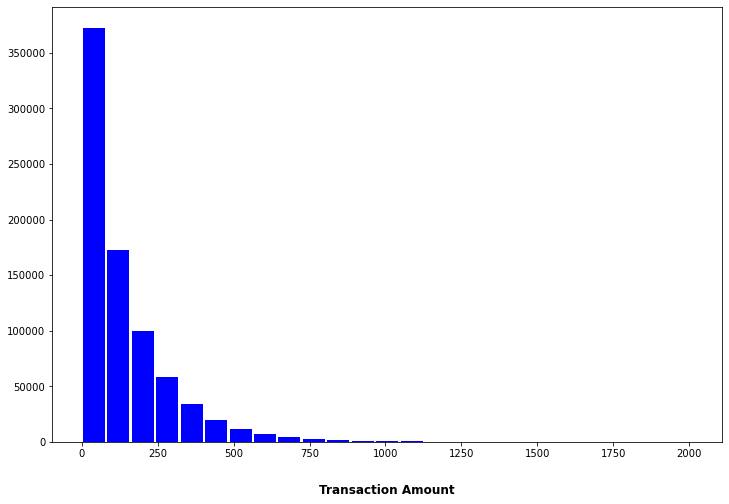

In [17]:
ax = df.hist(column='transactionAmount', bins=25, grid=False, figsize=(12,8), color='blue',zorder=2,rwidth=0.9)
ax = ax[0]
for x in ax:
    x.set_title("")
    x.set_xlabel("Transaction Amount", labelpad=25, weight='bold', size=12)

In [18]:
df["transactionAmount"].mode().iat[0]

0.0

In [19]:
df["transactionAmount"].mean()

136.98579095150615

In [20]:
df["transactionAmount"].median()

87.9

The distribution of the transaction amount is heavily right-skewed since the most of transactions are relatively small. The mean value of all transactions is 136.99, the median is 87.9, the mode is 0 and the largest transaction is 2011.54. 

Because of right-skewed, we may need to determine the best-fit distribution from Weibull family, Gamma family, Chi-square family, Lognormal family, or Power lognormal family. We also may need to consider a normalizing transformation such as the Box-Cox transformation.


## Duplicate Transactions



### Reversed Transactions

Next step, we want to find reversed transaction.

In [21]:
df['transactionType'].unique()

array(['PURCHASE', 'ADDRESS_VERIFICATION', 'REVERSAL', nan], dtype=object)


There are 3 types of transactions: PURCHASE, ADDRESS_VERIFICATION, and REVERSAL. Also, dataset misses transaction type for some transactions (0.09% of total transactions)

In [22]:
df_reversal=df.loc[df.transactionType=='REVERSAL']
df_reversal=df_reversal.reset_index(drop=True)
#df_reversal.head()

In [23]:
df_reversal.shape[0]

20303

In [24]:
total_reverse=df_reversal['transactionAmount'].sum()
total_reverse

2821792.5


There are 20,303 reversed transactions with the total amount of $2,821,792.5


### Multi-swipe  Transactions

Next we find all multi-swipe transactions. We determine transactions as multiple-swipe if there are two transactions have same customer ID, merchant name, transaction amount, and transaction type. However, these transactions should happen within a short time span. In the next step, we want to understand how to define this time period. 

In [25]:
df['transactionDateTime'] = pd.to_datetime(df['transactionDateTime'])

dft=df.copy()

dft['time_dif'] = (dft.sort_values(['transactionDateTime'])
                       .groupby(['customerId','merchantName', 'transactionAmount','transactionType'], sort=False)['transactionDateTime']
                       .diff()
                       .dt.total_seconds()/60)


We look at the time differences between transactions with the same customer ID, merchant name, transaction amount, and transaction type. In the below plot, we can see most of them happen in less than 10 minutes as we expected. 

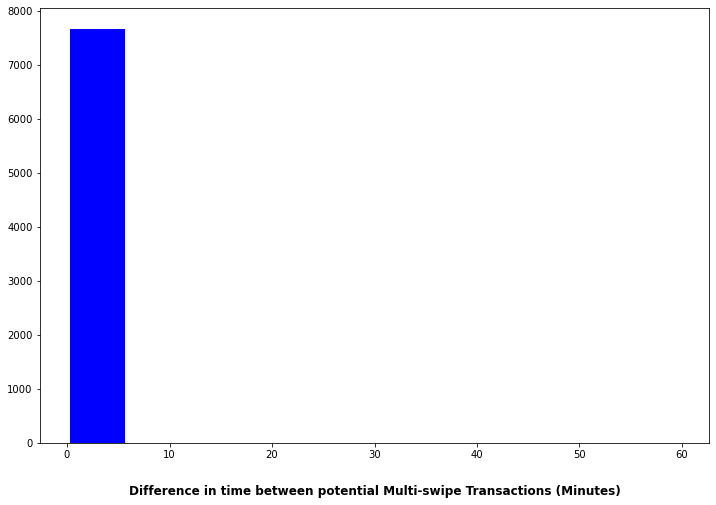

In [26]:
ax = dft.hist(column='time_dif', bins=10,range=[0, 60], grid=False, figsize=(12,8), color='blue',zorder=2,rwidth=0.9)
ax = ax[0]
for x in ax:
    x.set_title("")
    x.set_xlabel("Difference in time between potential Multi-swipe Transactions (Minutes)",weight='bold', labelpad=25, size=12)

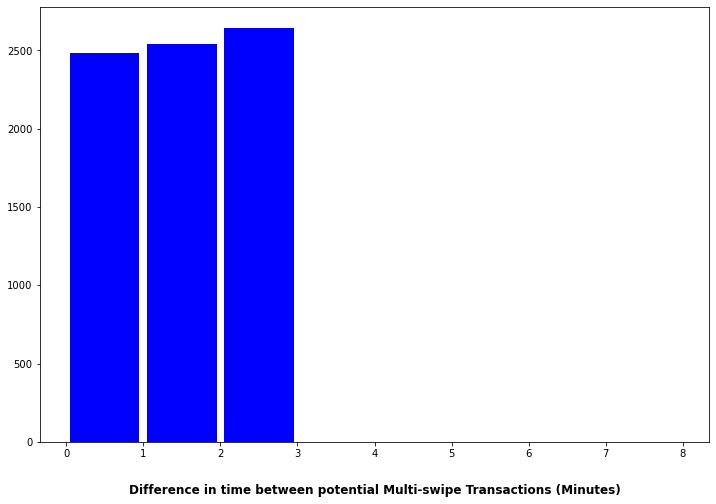

In [27]:
ax = dft.hist(column='time_dif', bins=8,range=[0, 8], grid=False, figsize=(12,8), color='blue',zorder=2,rwidth=0.9)
ax = ax[0]
for x in ax:
    x.set_title("")
    x.set_xlabel("Difference in time between potential Multi-swipe Transactions (Minutes)",weight='bold', labelpad=25, size=12)


We plot again these transactions and see that most of them happen in less than 3 miutes. So two transactions are multiple-swipe when they have same customer ID, merchant name, transaction amount, transaction type, and happen within 3 minutes

In [28]:
dft['MultiSwipe'] = (dft.sort_values(['transactionDateTime'])
                       .groupby(['customerId','merchantName', 'transactionAmount','transactionType'], sort=False)['transactionDateTime']
                       .diff()
                       .dt.total_seconds()
                       .lt(180))

df_multi=dft.loc[dft.MultiSwipe==True]
df_multi=df_multi.reset_index(drop=True)
#df_multi.head()

In [29]:
df_multi.shape[0]

7671

In [30]:
total_multi=df_multi['transactionAmount'].sum()
total_multi

1102920.99

There are 7,671 multi-swipe transactions with the total amount of $1,102,920.99